## Pymaceuticals Inc.

---

### Analysis 
text here

###### Initial Data Setup

In [245]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import seaborn as sns
import numpy as np

In [246]:
# Study data files
mouse_metadata_path = "data/Mouse_metadata.csv"
study_results_path = "data/Study_results.csv"

# Read the mouse data and the study results
mouse_metadata = pd.read_csv(mouse_metadata_path)
study_results = pd.read_csv(study_results_path)

In [247]:
mouse_metadata

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g)
0,k403,Ramicane,Male,21,16
1,s185,Capomulin,Female,3,17
2,x401,Capomulin,Female,16,15
3,m601,Capomulin,Male,22,17
4,g791,Ramicane,Male,11,16
...,...,...,...,...,...
244,z314,Stelasyn,Female,21,28
245,z435,Propriva,Female,12,26
246,z581,Infubinol,Female,24,25
247,z795,Naftisol,Female,13,29


In [248]:
mouse_metadata.dtypes

Mouse ID        object
Drug Regimen    object
Sex             object
Age_months       int64
Weight (g)       int64
dtype: object

In [249]:
study_results

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites
0,b128,0,45.000000,0
1,f932,0,45.000000,0
2,g107,0,45.000000,0
3,a457,0,45.000000,0
4,c819,0,45.000000,0
...,...,...,...,...
1888,r944,45,41.581521,2
1889,u364,45,31.023923,3
1890,p438,45,61.433892,1
1891,x773,45,58.634971,4


In [250]:
study_results.nunique()

Mouse ID               249
Timepoint               10
Tumor Volume (mm3)    1644
Metastatic Sites         5
dtype: int64

In [251]:
study_results.dtypes

Mouse ID               object
Timepoint               int64
Tumor Volume (mm3)    float64
Metastatic Sites        int64
dtype: object

> Merge notes 

There are 248 patient codes but 1893 study results entries, handling on average, between 7 or 8 entries per patient. 



In [252]:
## merge datasets

patient_data = pd.merge(mouse_metadata,
                        study_results, 
                        how='outer')

patient_data.head(15)

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
0,k403,Ramicane,Male,21,16,0,45.000000,0
1,k403,Ramicane,Male,21,16,5,38.825898,0
2,k403,Ramicane,Male,21,16,10,35.014271,1
3,k403,Ramicane,Male,21,16,15,34.223992,1
4,k403,Ramicane,Male,21,16,20,32.997729,1
5,k403,Ramicane,Male,21,16,25,33.464577,1
6,k403,Ramicane,Male,21,16,30,31.099498,1
7,k403,Ramicane,Male,21,16,35,26.546993,1
8,k403,Ramicane,Male,21,16,40,24.365505,1
9,k403,Ramicane,Male,21,16,45,22.050126,1


## __Datset Cleaning Methodology__

1. Identify the sequence of timepoints and compare number of entries per timepoint. Should be 225 per timepoint grouping.
2. Run Mouse ID in grouping to filter patient dataset

Comaprative analysis for projections if:
> A.1 - first duplicate is dropped \\\
> A.2 - second duplicate is dropped \\\
> A.3 - averaging both \\\
> A.4 - taking the smaller tumor volume \\\
> A.5 - taking the larger tumor volume \\

3. Compare delta between dropping the second ID, and proceed to summary statistics.

In [253]:
patient_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1893 entries, 0 to 1892
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Mouse ID            1893 non-null   object 
 1   Drug Regimen        1893 non-null   object 
 2   Sex                 1893 non-null   object 
 3   Age_months          1893 non-null   int64  
 4   Weight (g)          1893 non-null   int64  
 5   Timepoint           1893 non-null   int64  
 6   Tumor Volume (mm3)  1893 non-null   float64
 7   Metastatic Sites    1893 non-null   int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 133.1+ KB


In [254]:
patient_data.nunique()

Mouse ID               249
Drug Regimen            10
Sex                      2
Age_months              24
Weight (g)              16
Timepoint               10
Tumor Volume (mm3)    1644
Metastatic Sites         5
dtype: int64

#### Grouping Patients by Timepoint and Mouse ID

There are 249 unique mouse patients, only of which 130 mouse ID's can be identified with the sum of all timepoints to be 225. These entries will be classified as "reported" with high confidence that 100% of the timepoint data was collected. In terms of percentages, **52% of the unique number of patients have all 10 timepoints logged in the data portal.**

> **logic** : of 249 mouse patients, and 10 timpoints each ( 0-45 in increments of 5), there should be about 2490 entries to the patient data. 

There is currently only 1893 entries to the patient data entries, indicating there are some entries that were not reported. The incomplete timepoint entries will be classified as "review" patients, to indicate that some QAQC might be needed. 

In [255]:
patient_bygroup = pd.DataFrame(patient_data.groupby(['Mouse ID'])['Timepoint'].sum(numeric_only=True)).reset_index()

In [256]:
patient_bygroup['Mouse ID'].nunique()

249

In [257]:
# Marking grouped Mouse ID by wether or not all timepoints were completed, i.e. a sum of 225.
# False = patient did not record all timepoints 
# True = patient recorded all timepoints
patient_bygroup['Incomplete?'] = patient_bygroup['Timepoint'] < 225


In [258]:
review_patients = patient_bygroup[-(patient_bygroup['Incomplete?']== False)]

#### Identifying duplicate entries

By default the duplicated funciton will try to identify the duplicated patient.

In [259]:
#Identifying the duplicates
duplicate_finder = patient_data[patient_data.duplicated(subset=['Mouse ID','Timepoint'])]

duplicate_finder

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
909,g989,Propriva,Female,21,26,0,45.000000,0
911,g989,Propriva,Female,21,26,5,47.570392,0
913,g989,Propriva,Female,21,26,10,49.880528,0
915,g989,Propriva,Female,21,26,15,53.442020,0
917,g989,Propriva,Female,21,26,20,54.657650,1


In [260]:
# Observing all the values for duplicated Mouse ID
duplicate_analysis = patient_data.loc[patient_data['Mouse ID'] == 'g989']
duplicate_analysis

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
908,g989,Propriva,Female,21,26,0,45.000000,0
909,g989,Propriva,Female,21,26,0,45.000000,0
910,g989,Propriva,Female,21,26,5,48.786801,0
911,g989,Propriva,Female,21,26,5,47.570392,0
912,g989,Propriva,Female,21,26,10,51.745156,0
913,g989,Propriva,Female,21,26,10,49.880528,0
914,g989,Propriva,Female,21,26,15,51.325852,1
915,g989,Propriva,Female,21,26,15,53.442020,0
916,g989,Propriva,Female,21,26,20,55.326122,1
917,g989,Propriva,Female,21,26,20,54.657650,1


In [261]:
# Comparative Analysis 

# option A.1: drop first duplicate
da_A1 = duplicate_analysis.drop_duplicates(subset=['Mouse ID','Timepoint'], keep='last')\
.reset_index()

# option A.2: drop second duplicate
da_A2 = duplicate_analysis.drop_duplicates(subset=['Mouse ID','Timepoint'], keep='first')\
.reset_index()


In [262]:
# option A.3: average both duplicates
da_A3 = duplicate_analysis.groupby(['Mouse ID', 'Timepoint'])\
    .agg({'Tumor Volume (mm3)': 'mean',
          'Drug Regimen': 'first',
           'Sex': 'first',
            'Age_months': 'first',
            'Weight (g)': 'first',
            'Metastatic Sites': 'first'}).reset_index()


In [263]:
# option A.4: take the smaller tumor volume
da_A4 = duplicate_analysis.sort_values(by='Tumor Volume (mm3)')\
    .drop_duplicates(subset=['Mouse ID','Timepoint'], keep='first')\
    .reset_index()

# option A.5: take the larger tumor volume
da_A5 = duplicate_analysis.sort_values(by='Tumor Volume (mm3)')\
    .drop_duplicates(subset=['Mouse ID','Timepoint'], keep='last')\
    .reset_index()

In [264]:
# Comparing the tumor volumes
da_comparative_tumorvols = pd.DataFrame({
    'Option A.1': da_A1['Tumor Volume (mm3)'],
    'Option A.2': da_A2['Tumor Volume (mm3)'],
    'Option A.3': da_A3['Tumor Volume (mm3)'],
    'Option A.4': da_A4['Tumor Volume (mm3)'],
    'Option A.5': da_A5['Tumor Volume (mm3)'],
})

In [265]:
da_comparative_tumorvols.describe()

,Option A.1,Option A.2,Option A.3,Option A.4,Option A.5
count,8.000000,8.000000,8.000000,8.000000,8.000000
mean,53.531166,53.735334,53.633250,53.266645,53.999855
std,5.876944,5.670539,5.745062,5.928925,5.590882
min,45.000000,45.000000,45.000000,45.000000,45.000000
25%,49.302994,50.691089,50.154281,49.302994,51.005567
50%,54.049835,53.535639,53.687911,52.991751,54.384071
75%,56.804746,56.804746,56.804746,56.804746,56.804746
max,62.570880,62.570880,62.570880,62.570880,62.570880


## Data Cleaninig Conclusions 

While this analysis is looking at the effectiveness of the drug regimen, it is important to notate that a little over half of the patients had all 10 timepoints documented. This could potentially hint at the rate of survival of the patients, information that is not documented here. 

This particular case of Propiva that was over documented raises concerns not about the end result (after timepoint #25, all cleaning options align), but of the tumor growth and metastatic site observations. 

For example, if we choose option A.2, which is to drop the second duplicated item, the graph documents how the tumor volume actually shrinks before metastasicing. It would be prudent to contact the laboratory techicians to ensure the methodology and results match with the initial intent of the study. 

>**However, the study methodology asks to drop the patient all together, leaving the study with only 248 patients to graph and chart.**

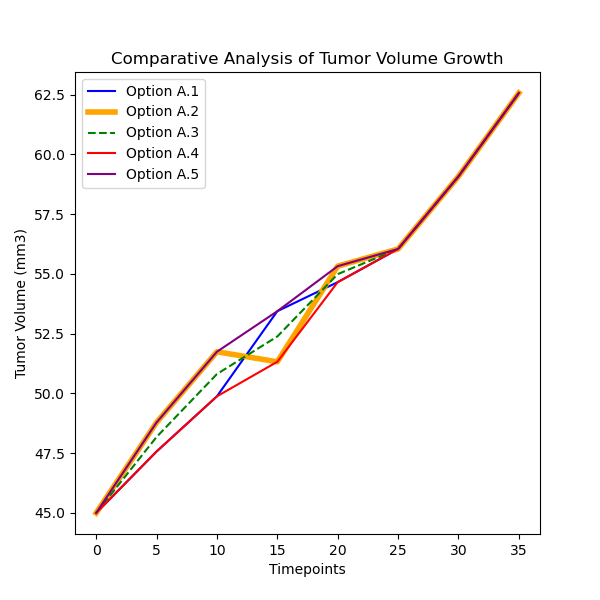

In [266]:
## Plot instructions 

# Create a new figure
plt.figure(figsize=(6, 6))

# Plot each line for the analysis options
plt.plot(da_A1['Timepoint'], da_A1['Tumor Volume (mm3)'], label='Option A.1', color='blue')
plt.plot(da_A2['Timepoint'], da_A2['Tumor Volume (mm3)'], linewidth=4, label='Option A.2', color='orange')
plt.plot(da_A3['Timepoint'], da_A3['Tumor Volume (mm3)'], linestyle="--", label='Option A.3', color='green')
plt.plot(da_A4['Timepoint'], da_A4['Tumor Volume (mm3)'], label='Option A.4', color='red')
plt.plot(da_A5['Timepoint'], da_A5['Tumor Volume (mm3)'], label='Option A.5', color='purple')

# Set axis labels and title
plt.xlabel('Timepoints')
plt.ylabel('Tumor Volume (mm3)')
plt.title('Comparative Analysis of Tumor Volume Growth')

# Add legend
plt.legend()
plt.show()

In [267]:
# Comparing the metastatic sites
da_comparative_metasites = pd.DataFrame({
    'Option A.1': da_A1['Metastatic Sites'],
    'Option A.2': da_A2['Metastatic Sites'],
    'Option A.3': da_A3['Metastatic Sites'],
    'Option A.4': da_A4['Metastatic Sites'],
    'Option A.5': da_A5['Metastatic Sites'],
})

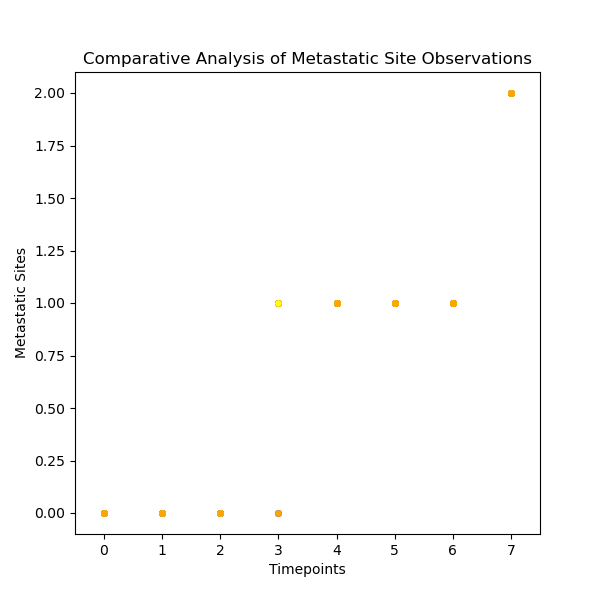

In [268]:
## Plot Instructions

# Create a new figure 
plt.figure(figsize=(6, 6))

# Scatter plot of metastatic sites
p1 = sns.stripplot(x=da_comparative_metasites.index, y='Option A.1', data=da_comparative_metasites, order=da_comparative_metasites.index,color='blue')
p2 = sns.stripplot(x=da_comparative_metasites.index, y='Option A.2', data=da_comparative_metasites, order=da_comparative_metasites.index,color='green')
p3 = sns.stripplot(x=da_comparative_metasites.index, y='Option A.3', data=da_comparative_metasites, order=da_comparative_metasites.index,color='red')
p4 = sns.stripplot(x=da_comparative_metasites.index, y='Option A.4', data=da_comparative_metasites, order=da_comparative_metasites.index,color='yellow')
p5 = sns.stripplot(x=da_comparative_metasites.index, y='Option A.5', data=da_comparative_metasites, order=da_comparative_metasites.index,color='orange')

# Set axis labels and title
plt.xlabel('Timepoints')
plt.ylabel('Metastatic Sites')
plt.title('Comparative Analysis of Metastatic Site Observations')
plt.show()

# Summary Statistics

In [269]:
# Create a clean DataFrame by dropping the duplicate mouse by its ID.
clean_patient_data = patient_data[patient_data['Mouse ID']!= 'g989']

In [270]:
clean_patient_data

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
0,k403,Ramicane,Male,21,16,0,45.000000,0
1,k403,Ramicane,Male,21,16,5,38.825898,0
2,k403,Ramicane,Male,21,16,10,35.014271,1
3,k403,Ramicane,Male,21,16,15,34.223992,1
4,k403,Ramicane,Male,21,16,20,32.997729,1
...,...,...,...,...,...,...,...,...
1888,z969,Naftisol,Male,9,30,25,63.145652,2
1889,z969,Naftisol,Male,9,30,30,65.841013,3
1890,z969,Naftisol,Male,9,30,35,69.176246,4
1891,z969,Naftisol,Male,9,30,40,70.314904,4


In [271]:
# Checking the number of mice in the clean DataFrame.
clean_patient_data['Mouse ID'].nunique()

248

In [272]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen

# Use groupby and summary statistical methods to calculate the following properties of each drug regimen: 
# mean, median, variance, standard deviation, and SEM of the tumor volume. 
# Assemble the resulting series into a single summary DataFrame.

summary_stats1 = clean_patient_data.groupby('Drug Regimen')['Tumor Volume (mm3)'].agg(['mean', 'median', 'var', 'std', 'sem'])

In [273]:
# Renaming the columns to match
summary_stats1 = summary_stats1.rename(columns={'mean': 'Mean Tumor Volume',
                                              'median': 'Median Tumor Volume',
                                              'var': 'Tumor Volume Variance',
                                              'std': 'Tumor Volume Std. Dev.',
                                              'sem': 'Tumor Volume Std. Err.'})
summary_stats1

,Mean Tumor Volume,Median Tumor Volume,Tumor Volume Variance,Tumor Volume Std. Dev.,Tumor Volume Std. Err.
Drug Regimen,,,,,
Capomulin,40.675741,41.557809,24.947764,4.994774,0.329346
Ceftamin,52.591172,51.776157,39.290177,6.268188,0.469821
Infubinol,52.884795,51.820584,43.128684,6.567243,0.492236
Ketapril,55.235638,53.698743,68.553577,8.279709,0.603860
Naftisol,54.331565,52.509285,66.173479,8.134708,0.596466
Placebo,54.033581,52.288934,61.168083,7.821003,0.581331
Propriva,52.320930,50.446266,43.852013,6.622085,0.544332
Ramicane,40.216745,40.673236,23.486704,4.846308,0.320955
Stelasyn,54.233149,52.431737,59.450562,7.710419,0.573111


In [274]:
summary_stats2 = clean_patient_data.groupby('Drug Regimen').agg({'Tumor Volume (mm3)': ['mean', 'median', 'var', 'std', 'sem']})
summary_stats2

Tumor Volume (mm3)                                          
                           mean     median        var       std       sem
Drug Regimen                                                             
Capomulin             40.675741  41.557809  24.947764  4.994774  0.329346
Ceftamin              52.591172  51.776157  39.290177  6.268188  0.469821
Infubinol             52.884795  51.820584  43.128684  6.567243  0.492236
Ketapril              55.235638  53.698743  68.553577  8.279709  0.603860
Naftisol              54.331565  52.509285  66.173479  8.134708  0.596466
Placebo               54.033581  52.288934  61.168083  7.821003  0.581331
Propriva              52.320930  50.446266  43.852013  6.622085  0.544332
Ramicane              40.216745  40.673236  23.486704  4.846308  0.320955
Stelasyn              54.233149  52.431737  59.450562  7.710419  0.573111
Zoniferol             53.236507  51.818479  48.533355  6.966589  0.516398

# Bar and Pie Charts

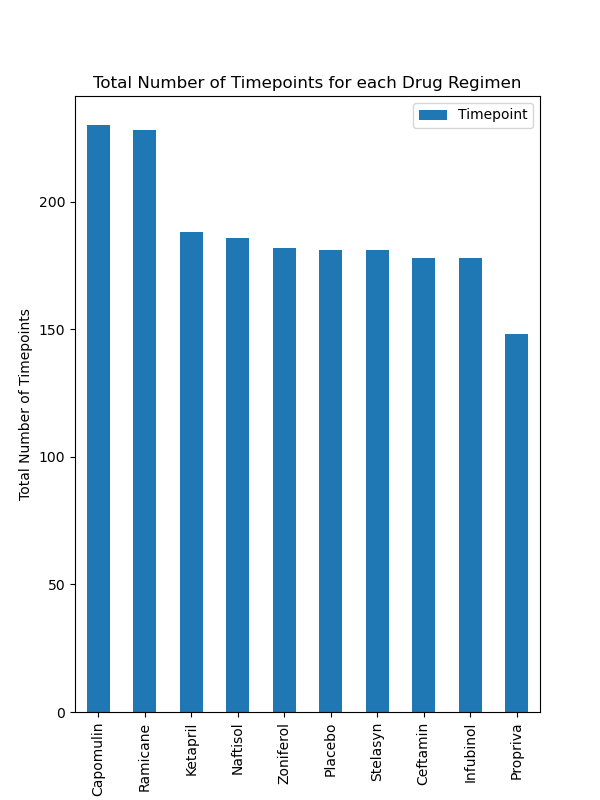

In [275]:
# Bar illustrating the number of timepoints for each drug regimen 

timepoints_data = pd.DataFrame(clean_patient_data.groupby('Drug Regimen')['Timepoint'].count())
timepoints_data = timepoints_data.sort_values(by='Timepoint',ascending=False)

## Plot instructions 

# Plot type
timepoints_data.plot(kind='bar', figsize=(6, 8))

# Title and Labels
plt.title('Total Number of Timepoints for each Drug Regimen')
plt.xlabel('Drug Regimen')
plt.ylabel('Total Number of Timepoints')
plt.show()

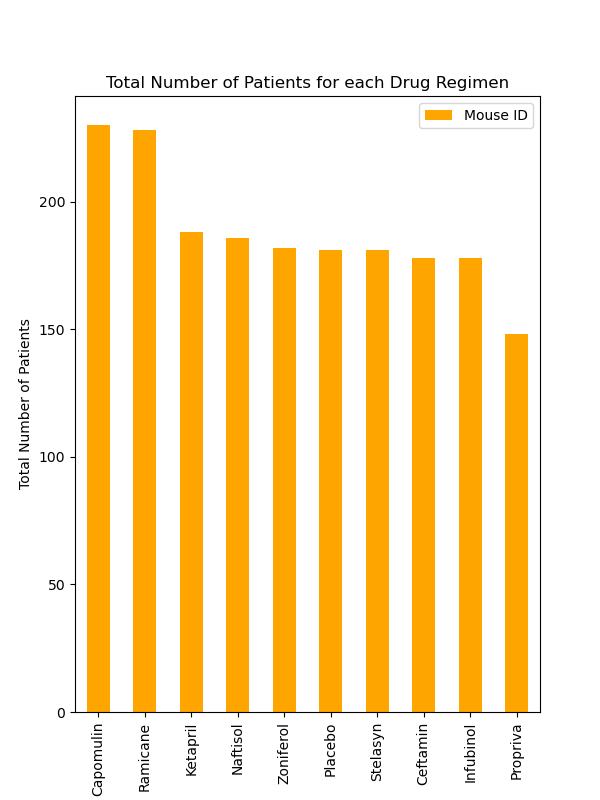

In [276]:
# Bar illustrating the number of patients for each drug regimen 

timepoints_data = pd.DataFrame(clean_patient_data.groupby('Drug Regimen')['Mouse ID'].count())
timepoints_data = timepoints_data.sort_values(by='Mouse ID',ascending=False)

## Plot instructions 

# Plot type
timepoints_data.plot(kind='bar', figsize=(6, 8), color='orange')

# Title and Labels
plt.title('Total Number of Patients for each Drug Regimen')
plt.xlabel('Drug Regimen')
plt.ylabel('Total Number of Patients')
plt.show()

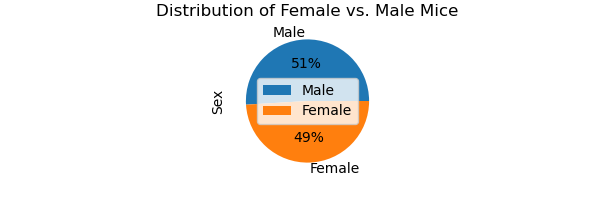

In [277]:
# Create a new DataFrame with the count of male and female mice
gender_counts = pd.DataFrame(clean_patient_data['Sex'].value_counts())


## Plot instructions
# Panda plot
gender_counts.plot(kind='pie', y='Sex', figsize=(6,2), autopct='%1.f%%')

# Set title and labels
plt.title('Distribution of Female vs. Male Mice')
plt.show()


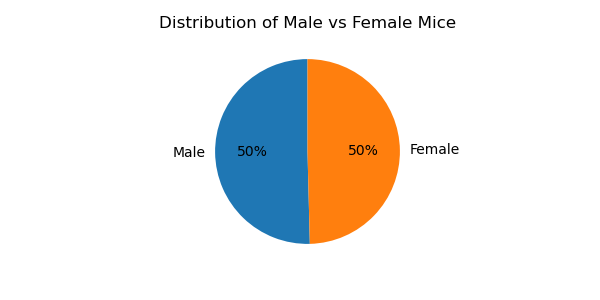

In [278]:
# Count the number of male and female mice
male_count = clean_patient_data[clean_patient_data['Sex'] == 'Male']['Mouse ID'].nunique()
female_count = clean_patient_data[clean_patient_data['Sex'] == 'Female']['Mouse ID'].nunique()

# Create a list of counts and labels
counts = [male_count, female_count]
labels = ['Male', 'Female']

## Plot instructions 
# Set the figure size
plt.figure(figsize=(6,3))

# Create the pie chart
plt.pie(counts, labels=labels, autopct='%1.f%%', startangle=90)

# Add a title
plt.title('Distribution of Male vs Female Mice')
plt.show()

# Quartiles, Outliers and Boxplots

In [279]:
# Calculate the final tumor volume of each mouse across four of the treatment regimens:  
# Capomulin, Ramicane, Infubinol, and Ceftamin
four_drugs = clean_patient_data[clean_patient_data['Drug Regimen'].isin(['Capomulin', 'Ramicane', 'Infubinol', 'Ceftamin'])]

# Start by getting the last (greatest) timepoint for each mouse
last_timepoint = four_drugs.groupby('Mouse ID')['Timepoint'].max()
final_tumor_volume = pd.DataFrame({'Timepoint': last_timepoint})


# Merge this group df with the original DataFrame to get the tumor volume at the last timepoint
final_tumor_volume = pd.merge(final_tumor_volume, four_drugs, on=['Mouse ID', 'Timepoint'], how='left')[['Mouse ID', 'Timepoint', 'Tumor Volume (mm3)', 'Drug Regimen']]
final_tumor_volume.head()


,Mouse ID,Timepoint,Tumor Volume (mm3),Drug Regimen
0,a203,45,67.973419,Infubinol
1,a251,45,65.525743,Infubinol
2,a275,45,62.999356,Ceftamin
3,a411,45,38.407618,Ramicane
4,a444,45,43.047543,Ramicane


In [280]:
# Put treatments into a list for for loop (and later for plot labels)
treatments = ['Capomulin', 'Ramicane', 'Infubinol', 'Ceftamin']


# Create empty list to fill with tumor vol data (for plotting)
charted_volumes = []

for treatment in treatments:
    treatment_volumes = final_tumor_volume.loc[final_tumor_volume['Drug Regimen'] == treatment].groupby('Mouse ID')[['Timepoint', 'Tumor Volume (mm3)']].max()['Tumor Volume (mm3)']
    charted_volumes.append(treatment_volumes)

# Calculate the IQR and quantitatively determine if there are any potential outliers. 
    quartiles = treatment_volumes.quantile([0.25, 0.5, 0.75])
    lower_quartile = quartiles[0.25]
    upper_quartile = quartiles[0.75]
    iqr = upper_quartile - lower_quartile
      
    # add subset 
    lower_bound = lower_quartile - 1.5 * iqr
    upper_bound = upper_quartile + 1.5 * iqr
    
    # Determine outliers using upper and lower bounds
    outliers = treatment_volumes.loc[(treatment_volumes < lower_bound) | (treatment_volumes > upper_bound)]
    print(f"{treatment}'s potential outliers: {outliers}")



Capomulin's potential outliers: Series([], Name: Tumor Volume (mm3), dtype: float64)
Ramicane's potential outliers: Series([], Name: Tumor Volume (mm3), dtype: float64)
Infubinol's potential outliers: Mouse ID
c326    36.321346
Name: Tumor Volume (mm3), dtype: float64
Ceftamin's potential outliers: Series([], Name: Tumor Volume (mm3), dtype: float64)


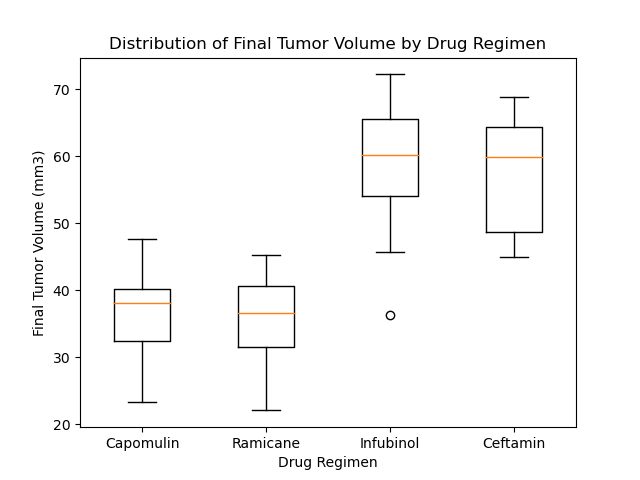

In [287]:
# Generate a box plot that shows the distrubution of the tumor volume for each treatment group.

# Create a list of tumor volumes for each treatment group
tumor_volumes1 = [list(volume) for volume in charted_volumes]

## Plot instructions 

# Create a boxplot
fig, ay = plt.subplots()
ay.boxplot(tumor_volumes1)

# Set the x-axis tick labels
ay.set_xticklabels(treatments)

# Add axis labels and title
ay.set_xlabel('Drug Regimen')
ay.set_ylabel('Final Tumor Volume (mm3)')
ay.set_title('Distribution of Final Tumor Volume by Drug Regimen')
plt.show()

# Line and Scatter Plots

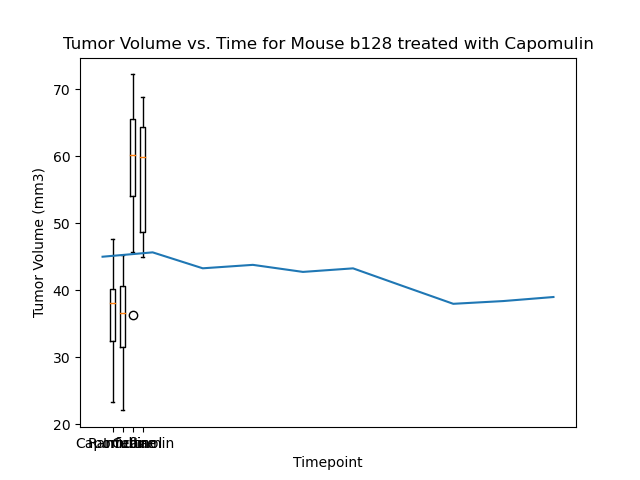

In [288]:
# Generate a line plot of tumor volume vs. time point for a mouse treated with Capomulin

# Find a mouse treated with Capomulin
mouse_id = final_tumor_volume.loc[final_tumor_volume['Drug Regimen'] == 'Capomulin']['Mouse ID'].iloc[0]

# Filter data for that mouse
mouse_data = clean_patient_data.loc[clean_patient_data['Mouse ID'] == mouse_id]

## Plot instructions

# Create line plot
plt.plot(mouse_data['Timepoint'], mouse_data['Tumor Volume (mm3)'])

# Set plot labels and title
plt.xlabel('Timepoint')
plt.ylabel('Tumor Volume (mm3)')
plt.title(f"Tumor Volume vs. Time for Mouse {mouse_id} treated with Capomulin")
plt.show()


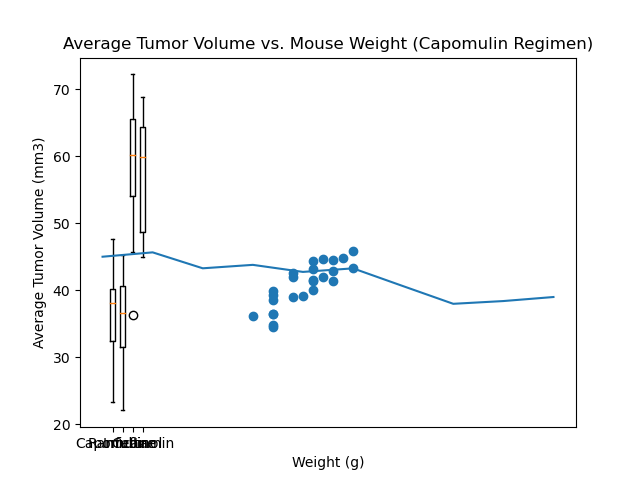

In [290]:
# Generate a scatter plot of average tumor volume vs. mouse weight for the Capomulin regimen

# Filter data for Capomulin regimen
capomulin_data = clean_patient_data.loc[clean_patient_data["Drug Regimen"] == "Capomulin"]

# Calculate average tumor volume and mouse weight by grouping data by Mouse ID
avg_data = capomulin_data.groupby("Mouse ID").agg({"Tumor Volume (mm3)": "mean", "Weight (g)": "mean"})

## Plot instructions

# Create scatter plot
plt.scatter(avg_data["Weight (g)"], avg_data["Tumor Volume (mm3)"])

# Set chart title and axis labels
plt.title("Average Tumor Volume vs. Mouse Weight (Capomulin Regimen)")
plt.xlabel("Weight (g)")
plt.ylabel("Average Tumor Volume (mm3)")

# Show plot
plt.show()

# Correlation and Regression

Correlation Coefficient: 0.841936342469472


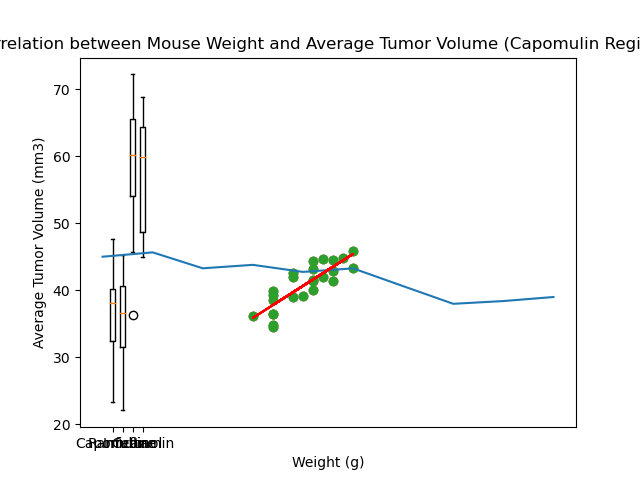

In [292]:
# Calculate the correlation coefficient and linear regression model 
# for mouse weight and average tumor volume for the Capomulin regimen

from scipy.stats import pearsonr, linregress

# Get the data for Capomulin regimen
capomulin_data = clean_patient_data.loc[clean_patient_data["Drug Regimen"] == "Capomulin"]

# Calculate the average tumor volume and weight for each mouse
avg_data = capomulin_data.groupby("Mouse ID").mean(numeric_only=True)[["Weight (g)", "Tumor Volume (mm3)"]]

# Generate a scatter plot of the data
x = avg_data["Weight (g)"]
y = avg_data["Tumor Volume (mm3)"]
plt.scatter(x, y)

# Calculate the correlation coefficient
r, p_value = pearsonr(x, y)
print("Correlation Coefficient:", r)

# Calculate the linear regression model
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Add the linear regression line to the plot
plt.plot(x, intercept + slope*x, 'r')

# Add labels and title to the plot
plt.xlabel("Weight (g)")
plt.ylabel("Average Tumor Volume (mm3)")
plt.title("Correlation between Mouse Weight and Average Tumor Volume (Capomulin Regimen)")

# Show the plot
plt.show()

